In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import SGDRegressor as SGD

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 3)

In [2]:
df = pd.read_csv('../craigslist_data/QGIS/df_final_qgis.csv')

In [3]:
df = df.drop(['index'], axis = 1)

https://data.sfgov.org/Housing-and-Buildings/San-Francisco-Rental-Listings-06-2012-12-2012/c2ie-3fuy

Listings from 06/2012 - 12/2012

http://propertymap.sfplanning.org/maphelp.html

Maps of SF neighborhoods: defined by the Mayor's Office and Planning Department 

http://www.zillow.com/san-francisco-ca/home-values/

In [4]:
SF_gov = pd.read_csv('../craigslist_data/QGIS/sf_gov_with_neighborhoods.csv')

In [5]:
SF_gov = SF_gov.drop('field_1', axis =1).rename(columns = {'neighborho' : 'neighborhood'})

In [6]:
SF_gov = SF_gov.drop(['X', 'Y'], axis = 1)

In [7]:
len(df.post_id)

13556

In [8]:
len(df.post_id.unique())

13556

In [9]:
# finding repeat urls in data
double_ids = df.groupby('url').count().sort(columns = 'longitude')[::-1].longitude[df.groupby('url').count().sort(columns = 'longitude')[::-1].longitude == 2].index

In [10]:
double_df = df.set_index('url').loc[double_ids]

In [11]:
# double scraped
len(double_df)

0

In [12]:
groupUrl = double_df.groupby(double_df.index).rent

In [13]:
# finding repeat urls with changed rent prices
double_ids_diff = (groupUrl.mean() - groupUrl.min()).order()[::-1][(groupUrl.mean() - groupUrl.min()).order()[::-1] != 0].index

In [14]:
double_df_r = double_df.loc[double_ids_diff]

In [15]:
# duplicates with changed rents, so 13 edited postings
len(double_df_r)

0

In [16]:
df = df.rename(columns = {'neighborho' : 'user_Ns' , 'neighbor_2' : 'GIS_Ns'})

In [17]:
df = df[(df.rent > 1000) & (df.rent < 30000)]
SF_gov = SF_gov[(SF_gov.price > 1000) & (SF_gov.price < 30000)]

In [18]:
df = df[(df.sq_ft > 200) & (df.sq_ft < 12000) | (df.sq_ft.isnull())]

## Exporting Clean Data

In [19]:
#df.to_csv('../craigslist_data/QGIS/df_final_qgis.csv')

In [20]:
#SF_gov.to_csv('../craigslist_data/SFgov_rental_listings.csv')

In [21]:
df_partial = df.reset_index()[['index', 'latitude', 'longitude', 'rent', 'bedrooms', 'post_id']]

In [22]:
#df_partial.to_csv('../craigslist_data/QGIS/df_final_qgis_toPlot.csv')

## Descriptive

In [23]:
SF_gov.head()

,numBedroom,price,latitude,longitude,neighborhood
0,2,2200,37.71,-122.46,Ocean View
1,2,2300,37.71,-122.46,Ocean View
2,2,2200,37.71,-122.46,Ocean View
3,2,2000,37.71,-122.46,Ocean View
4,1,1150,37.71,-122.46,Ocean View


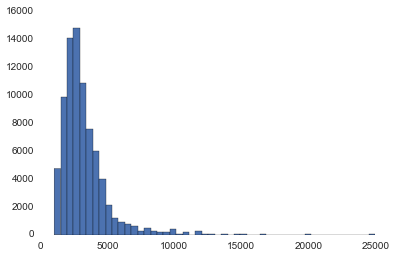

In [24]:
SF_gov.price.hist(bins = 50)

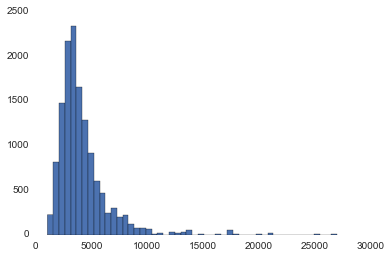

In [25]:
df.rent.hist(bins = 50)

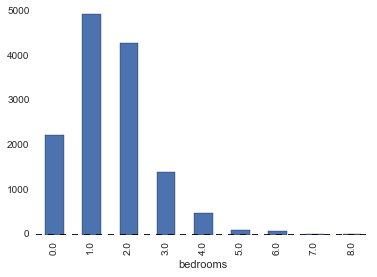

In [26]:
df.groupby('bedrooms').count().apa.plot(kind = 'bar')

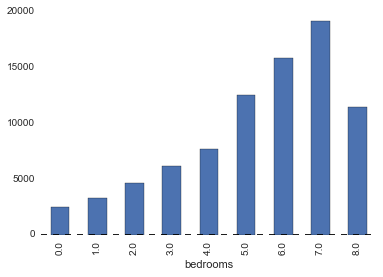

In [27]:
df.groupby('bedrooms').mean().rent.plot(kind = 'bar')

In [28]:
df.rent.mean()

4181.8529802301564

In [29]:
df.rent.median()

3595.0

In [30]:
df[df.sq_ft.notnull()].rent.mean()

4451.4997629957343

In [31]:
df[df.sq_ft.isnull()].rent.mean()

3945.7114985471148

In [32]:
df[df.sq_ft.notnull()].bedrooms.mean()

1.6168800379326695

In [33]:
df[df.sq_ft.isnull()].bedrooms.mean()

1.459717607973422

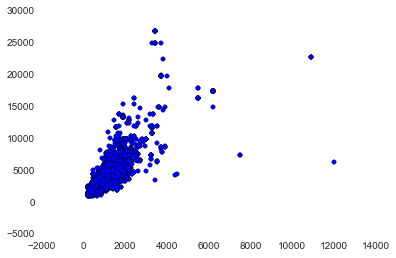

In [34]:
sq_ft_df = df[df.sq_ft.notnull()]
plt.scatter(sq_ft_df.sq_ft, sq_ft_df.rent)

In [35]:
df.rent.mean()

4181.8529802301564

In [36]:
SF_gov.price.mean()

3247.0714790522361

In [37]:
SF_gov.price.median()

2800.0

In [38]:
df.rent.median()

3595.0

In [39]:
sf_2015_Ns = df.groupby('GIS_Ns').rent.count().order()[::-1]

In [40]:
sf_2015_Ns = sf_2015_Ns[sf_2015_Ns > 30]

In [41]:
N_df = pd.DataFrame(sf_2015_Ns)

In [42]:
N_df['rent2012'] = SF_gov.groupby('neighborhood').price.median().astype(float)

In [43]:
N_df['rent2015'] = df.groupby('GIS_Ns').rent.median().astype(float)

In [44]:
#N_df[['X', 'Y']] = SF_gov.groupby('neighborhood')[['X','Y']].median()

In [45]:
N_df['rent_difference'] = N_df.rent2015 - N_df.rent2012

In [46]:
#N_df.to_csv('../craigslist_data/neighborhoods_rent_change.csv')

## Neighborhoods

In [47]:
df['GIS_Ns'].str.get_dummies().head()

,Bayview,Bernal Heights,Castro/Upper Market,Chinatown,Crocker Amazon,Diamond Heights,Downtown/Civic Center,Excelsior,Financial District,Glen Park,...,Presidio,Presidio Heights,Russian Hill,Seacliff,South of Market,Treasure Island/YBI,Twin Peaks,Visitacion Valley,West of Twin Peaks,Western Addition
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df_Ndummies = pd.concat([df.user_Ns, df['GIS_Ns'].str.get_dummies()], axis = 1)

In [49]:
df_UN = df_Ndummies.groupby('user_Ns').sum().transpose()

In [50]:
user_index_sub = df_UN.sum().order()[::-1][:38].index

In [51]:
df_UN = df_UN.loc[:,user_index_sub]

In [52]:
df_UN.columns

Index([u'soma  south beach', u'mission district', u'pacific heights', u'nob hill', u'downtown  civic  van ness', u'marina  cow hollow', u'castro  upper market', u'russian hill', u'sunset  parkside', u'lower pac hts', u'lower nob hill', u'potrero hill', u'richmond  seacliff', u'noe valley', u'ingleside  sfsu  ccsf', u'financial district', u'inner sunset  ucsf', u'hayes valley', u'inner richmond', u'tenderloin', u'north beach  telegraph hill', u'alamo square  nopa', u'glen park', u'twin peaks  diamond hts', u'laurel hts  presidio', u'excelsior  outer mission', u'bernal heights', u'cole valley  ashbury hts', u'usf  panhandle', u'haight ashbury', u'bayview', u'lower haight', u'west portal  forest hill', u'portola district', u'western addition', u'san francisco', u'visitacion valley', u'fillmore district'], dtype='object')

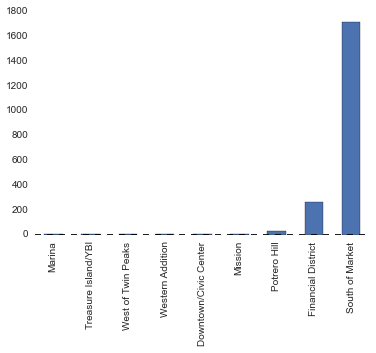

In [53]:
df_UN['soma  south beach'][df_UN['soma  south beach'] > 0].order().plot(kind = 'bar')

In [54]:
df_UN = df_UN.transpose()

In [55]:
for col in df_UN:
    print col
    print 
    print df_UN[col][df_UN[col] > 0].order(ascending = False)[:]
    print
    print

Bayview

user_Ns
bayview                     90
portola district             3
excelsior  outer mission     2
bernal heights               1
financial district           1
nob hill                     1
Name: Bayview, dtype: int64


Bernal Heights

user_Ns
bernal heights      121
mission district     56
noe valley            9
glen park             4
Name: Bernal Heights, dtype: int64


Castro/Upper Market

user_Ns
castro  upper market           419
mission district                58
twin peaks  diamond hts         29
noe valley                      20
lower haight                     9
cole valley  ashbury hts         6
hayes valley                     3
inner sunset  ucsf               3
glen park                        1
north beach  telegraph hill      1
Name: Castro/Upper Market, dtype: int64


Chinatown

user_Ns
nob hill                     69
financial district           13
lower nob hill                8
downtown  civic  van ness     3
richmond  seacliff            1
Name: Chin

In [56]:
df[df.GIS_Ns == 'Downtown/Civic Center'].groupby('user_Ns').rent.agg(['count', 'mean']).sort(columns = 'count')[::-1]

,count,mean
user_Ns,,
lower nob hill,384,2800.74
downtown civic van ness,346,2727.38
tenderloin,249,1938.71
hayes valley,64,3353.50
nob hill,26,2839.62
lower pac hts,10,3784.00
powell &amp; market,9,2920.67
san francisco,7,2625.71
soma south beach,5,4020.00


In [57]:
for col in df_UN:
    print col
    print 
    print df_UN[col][df_UN[col] > 0].order(ascending = False).index.tolist()
    print
    print

Bayview

['bayview', 'portola district', 'excelsior  outer mission', 'bernal heights', 'financial district', 'nob hill']


Bernal Heights

['bernal heights', 'mission district', 'noe valley', 'glen park']


Castro/Upper Market

['castro  upper market', 'mission district', 'twin peaks  diamond hts', 'noe valley', 'lower haight', 'cole valley  ashbury hts', 'hayes valley', 'inner sunset  ucsf', 'glen park', 'north beach  telegraph hill']


Chinatown

['nob hill', 'financial district', 'lower nob hill', 'downtown  civic  van ness', 'richmond  seacliff']


Crocker Amazon

['excelsior  outer mission', 'ingleside  sfsu  ccsf']


Diamond Heights

['twin peaks  diamond hts', 'glen park', 'castro  upper market', 'san francisco', 'noe valley']


Downtown/Civic Center

['lower nob hill', 'downtown  civic  van ness', 'tenderloin', 'hayes valley', 'nob hill', 'lower pac hts', 'san francisco', 'soma  south beach', 'financial district', 'russian hill', 'haight ashbury', 'castro  upper market']


Exce

## Tenderloin

In [58]:
df_alt_Ns = pd.read_csv('../craigslist_data/Mayor_Neighborhoods.csv')

In [59]:
df_alt_Ns = df_alt_Ns.drop(['X', 'Y', 'index', 'url', 'post_id', 'date_time', 'LINK'], axis = 1)

In [60]:
df_tenderloin = df_alt_Ns[df_alt_Ns.name == 'Tenderloin']

In [61]:
df_tenderloin['Tenderloin'] = 1

/Users/David/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [62]:
t_index = df_tenderloin[df_tenderloin.user_Ns == 'tenderloin'].index

In [63]:
df_tenderloin.ix[t_index, 'Tenderloin'] = 0

/Users/David/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [64]:
t_count = df_tenderloin.groupby('Tenderloin').count().rename(index = {1 : 'lying', 0 : 'honest'}, axis = 0)

In [65]:
t_count

,apa,bathrooms,bedrooms,cats_OK,dogs_OK,furnished,latitude,laundry,longitude,user_Ns,no smoking,parking,rent,sq_ft,wheelchair,GIS_Ns,name
Tenderloin,,,,,,,,,,,,,,,,,
honest,224,206,224,224,224,224,224,132,224,224,224,84,224,23,224,224,224
lying,243,224,243,243,243,243,243,196,243,238,243,153,243,69,243,243,243


In [66]:
t_median = df_tenderloin.groupby('Tenderloin').median().rename(index = {1 : 'lying', 0 : 'honest'}, axis = 0)

In [67]:
t_median

,bathrooms,bedrooms,cats_OK,dogs_OK,furnished,latitude,longitude,no smoking,rent,sq_ft,wheelchair
Tenderloin,,,,,,,,,,,
honest,1,0,1,1,0,37.78,-122.41,1,1795,450,0
lying,1,0,1,1,0,37.79,-122.42,1,2295,499,0


In [68]:
t_mean = df_tenderloin.groupby('Tenderloin').mean().rename(index = {1 : 'lying', 0 : 'honest'}, axis = 0)

In [69]:
t_mean

,bathrooms,bedrooms,cats_OK,dogs_OK,furnished,latitude,longitude,no smoking,rent,sq_ft,wheelchair
Tenderloin,,,,,,,,,,,
honest,1.00,0.22,0.84,0.82,0.00,37.78,-122.41,0.71,1850.04,461.74,0.01
lying,1.03,0.54,0.62,0.55,0.08,37.78,-122.42,0.57,2371.69,533.22,0.02


In [70]:
df_tenderloin.user_Ns[df_tenderloin.Tenderloin == 1].value_counts()

downtown  civic  van ness    151
lower nob hill                84
russian hill                   2
downtown                       1
dtype: int64

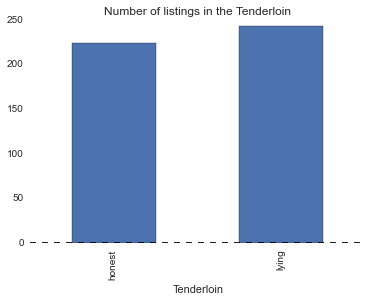

In [71]:
t_count.apa.plot(kind = 'bar', title = 'Number of listings in the Tenderloin', use_index = True);

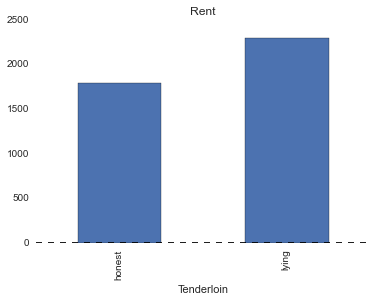

In [72]:
t_median['rent'].plot(kind = 'bar', title = 'Rent');

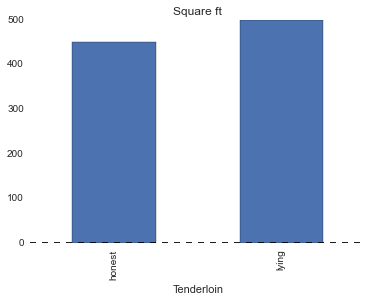

In [73]:
t_median['sq_ft'].plot(kind = 'bar', title = 'Square ft');

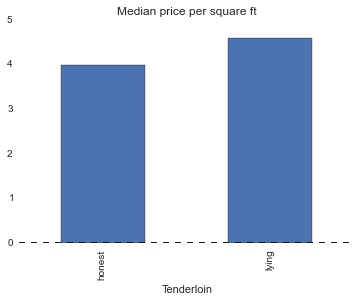

In [74]:
pd.DataFrame(t_median.rent / t_median.sq_ft).plot(kind = 'bar', title = 'Median price per square ft', legend = False);

In [75]:
Not_in_tenderloin = df_alt_Ns[(df_alt_Ns.name != 'Tenderloin') & (df_alt_Ns.user_Ns == 'tenderloin')]

In [76]:
# So if you're wondering

In [77]:
Not_in_tenderloin.name.value_counts().sum()

41

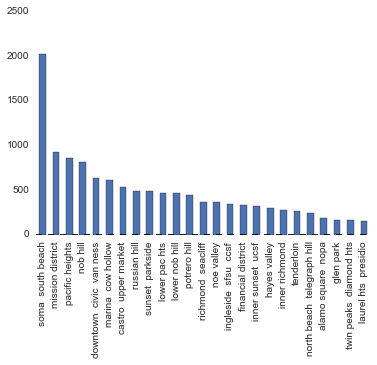

In [78]:
df.user_Ns.value_counts()[:25].plot(kind = 'bar')

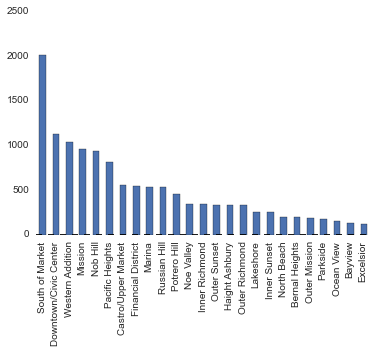

In [79]:
df.GIS_Ns.value_counts()[:25].plot(kind = 'bar')

In [80]:
df.groupby('GIS_Ns').count()

,apa,bathrooms,bedrooms,cats_OK,date_time,dogs_OK,furnished,latitude,laundry,longitude,user_Ns,no smoking,parking,post_id,rent,sq_ft,url,wheelchair
GIS_Ns,,,,,,,,,,,,,,,,,,
Bayview,131,126,131,131,131,131,131,131,72,131,109,131,116,131,131,108,131,131
Bernal Heights,192,188,192,192,192,192,192,192,121,192,191,192,105,192,192,85,192,192
Castro/Upper Market,553,539,553,553,553,553,553,553,369,553,552,553,331,553,553,254,553,553
Chinatown,99,93,99,99,99,99,99,99,72,99,96,99,52,99,99,24,99,99
Crocker Amazon,10,10,10,10,10,10,10,10,5,10,9,10,10,10,10,8,10,10
Diamond Heights,37,36,37,37,37,37,37,37,36,37,37,37,36,37,37,30,37,37
Downtown/Civic Center,1122,1028,1122,1122,1122,1122,1122,1122,835,1122,1116,1122,547,1122,1122,324,1122,1122
Excelsior,115,111,115,115,115,115,115,115,81,115,111,115,88,115,115,56,115,115
Financial District,540,530,540,540,540,540,540,540,389,540,538,540,293,540,540,309,540,540


In [81]:
SF_gov.price > 800

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
...
80638    True
80639    True
80640    True
80641    True
80642    True
80643    True
80644    True
80645    True
80646    True
80647    True
80648    True
80649    True
80650    True
80651    True
80652    True
Name: price, Length: 80653, dtype: bool

In [82]:
df_rent = df_alt_Ns[['latitude', 'longitude', 'rent']]

In [83]:
df_rent.to_csv('../craigslist_data/rent_only.csv')

## Predictive Models

### Predict Neighborhood?

In [122]:
np = df[['latitude', 'longitude', 'GIS_Ns']]
X = np.iloc[:,:2].values
y = df.GIS_Ns
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)
est = RF(n_estimators= 5)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
score = y_pred - y_test == 0
print 'precent inaccurate: ', float(len(score) - sum(score)) / len(score)

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [159]:
import numpy as np

In [175]:
np.logspace(.1, 2, 10).astype(int)

array([  1,   2,   3,   5,   8,  14,  23,  37,  61, 100])

In [ ]:
from sklearn.learning_curve import validation_curve

In [186]:
train_scores, test_scores = validation_curve(RF(), X, y, 'n_estimators', np.logspace(.1, 2, 10).astype(int))

In [193]:
test_scores.min()

0.95605858854860182

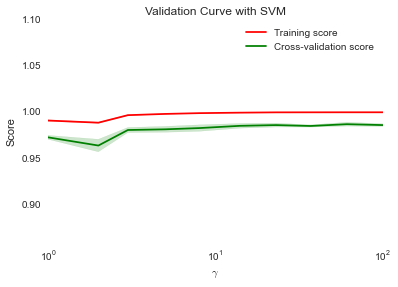

In [196]:
param_range = np.logspace(.1, 2, 10).astype(int)
train_scores, test_scores = validation_curve(
    RF(), X, y, 'n_estimators', np.logspace(.1, 2, 10).astype(int),
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(test_scores.min() -.1, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

In [179]:
valid_scores

array([[ 0.96116505,  0.97764498,  0.96893032],
       [ 0.96624007,  0.97277556,  0.96604527],
       [ 0.9755075 ,  0.98450642,  0.97958278],
       [ 0.98102383,  0.98517043,  0.98091434],
       [ 0.97992056,  0.9873838 ,  0.98158012],
       [ 0.98168579,  0.9873838 ,  0.98268975],
       [ 0.98323036,  0.98871182,  0.98335553],
       [ 0.9825684 ,  0.98782647,  0.98446516],
       [ 0.9825684 ,  0.98915449,  0.98712827],
       [ 0.98499559,  0.98915449,  0.98557479]])

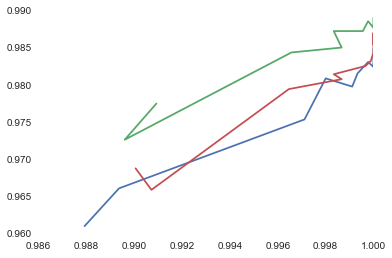

In [184]:
plt.plot(train_scores, valid_scores)

## First round, all inputs

In [362]:
def makeXy(df):
    le = preprocessing.LabelEncoder()
    df_le = pd.DataFrame()
    for col in df:
        if df[col].dtype == 'object':
            df_le[col] = le.fit_transform(df[col])
        else:
            df_le[col] = df[col]
    X = df_le.drop('rent', axis=1)
    im = preprocessing.Imputer(copy = False)
    X = im.fit_transform(X)
    X = preprocessing.scale(X)
    y = df_alt_Ns.rent.values
    return X, y

In [514]:
X, y = makeXy(df_alt_Ns)

In [515]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)

In [516]:
est = RF(n_estimators = 50)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print mean_squared_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred) **.5
print mean_absolute_error(y_test, y_pred)

467362.237389
683.638967137
270.339762611


In [517]:
def plot_pred(y_pred, y_test, y):
    # Compare y_pred and y_test values
    fig, ax = plt.subplots(1, 1)

    ax.scatter(y_pred, y_test)
    ax.set_xlabel('Predicated')
    ax.set_ylabel('Actual')

    # Draw the ideal line
    ax.plot(y, y, 'r')
    plt.show()

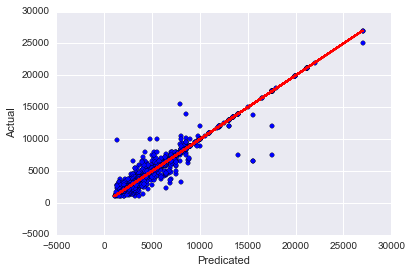

In [518]:
plot_pred(y_pred, y_test, y)

In [519]:
def f_importance(df_alt_Ns):
    cols = df_alt_Ns.drop('rent', axis = 1).columns
    return sorted(zip(est.feature_importances_, cols), reverse = True)

In [520]:
f_importance(df_alt_Ns)

[(0.1691223069872175, 'longitude'),
 (0.16702640107415598, 'latitude'),
 (0.11835318699721512, 'sq_ft'),
 (0.078907803138831639, 'name'),
 (0.069381567520546236, 'user_Ns'),
 (0.064757526278376443, 'parking'),
 (0.058262981773646236, 'GIS_Ns'),
 (0.054197302371383212, 'laundry'),
 (0.041032933396873181, 'bedrooms'),
 (0.040833107615318734, 'no smoking'),
 (0.03497668270127792, 'bathrooms'),
 (0.03407976921256331, 'apa'),
 (0.020701364663124361, 'cats_OK'),
 (0.018547739733596958, 'dogs_OK'),
 (0.016236165764310338, 'furnished'),
 (0.013583160771563036, 'wheelchair')]

In [521]:
len(y_pred - y_test)

2696

In [522]:
def percent_perfect(y_pred, y_test):
    percent = ((y_pred - y_test) == 0).sum() / float(len(y_pred - y_test))
    print 'percent perfect: ', percent

In [523]:
percent_perfect(y_pred, y_test)

percent perfect:  0.442136498516


In [581]:
df_alt_Ns.to_csv('../craigslist_data/df_predict.csv', index = False)

## Reduce Duplicates

In [585]:
SF_gov.to_csv('../craigslist_data/SF_gov_predict.csv', index = False)

## SF_GOV

In [373]:
X, y = makeXy(df_alt_Ns)

In [374]:
X = SF_gov.drop('price', axis = 1)
le = preprocessing.LabelEncoder()
X.ix[:,'neighborhood'] = le.fit_transform(X.neighborhood)
X = X.values

In [375]:
y = SF_gov.price

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)

In [377]:
%%time
est = RF(n_estimators = 10)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print mean_squared_error(y_test, y_pred)

611299.347778
CPU times: user 17 s, sys: 7.26 s, total: 24.2 s
Wall time: 27.2 s


In [378]:
print mean_squared_error(y_test, y_pred) **.5
print mean_absolute_error(y_test, y_pred)

781.856347277
308.377967888


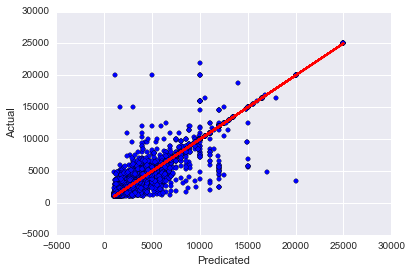

In [379]:
plot_pred(y_pred, y_test, y)

In [380]:
cols = SF_gov.drop('price', axis = 1).columns
sorted(zip(est.feature_importances_, cols), reverse = True)

[(0.46867932404708135, 'latitude'),
 (0.46431040616817654, 'longitude'),
 (0.041427757948157604, 'neighborhood'),
 (0.025582511836584498, 'numBedroom')]

In [381]:
percent_perfect(y_pred, y_test)

percent perfect:  0.340958403075


## Only Features in SF_Gov

In [382]:
sf_features = df_alt_Ns[['bedrooms', 'latitude', 'longitude', 'GIS_Ns', 'rent']]

In [383]:
X, y = makeXy(sf_features)

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)

In [385]:
%%time
est = RF(n_estimators = 50)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print mean_squared_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred) **.5
print mean_absolute_error(y_test, y_pred)

636947.021142
798.089607214
345.051557864
CPU times: user 8.5 s, sys: 2.78 s, total: 11.3 s
Wall time: 11.9 s


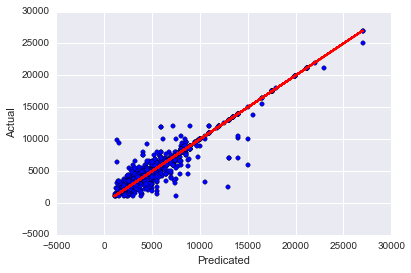

In [386]:
plot_pred(y_pred, y_test, y)

In [387]:
f_importance(sf_features)

[(0.44500610656051159, 'longitude'),
 (0.43802606468641619, 'latitude'),
 (0.073282780776778175, 'GIS_Ns'),
 (0.043685047976294265, 'bedrooms')]

In [388]:
percent_perfect(y_pred, y_test)

percent perfect:  0.392804154303


## Dealing with the perfect predicted scores

In [389]:
X, y = makeXy(df_alt_Ns)

In [390]:
X.shape[0] / 5

2695

In [391]:
X_train, X_test, y_train, y_test = X[:-2695], X[-2695:], y[:-2695], y[-2695:]

In [392]:
%%time
est = RF(n_estimators = 50)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print mean_squared_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred) **.5
print mean_absolute_error(y_test, y_pred)

710092.069017
842.669608457
372.515769944
CPU times: user 8.22 s, sys: 2.71 s, total: 10.9 s
Wall time: 11.7 s


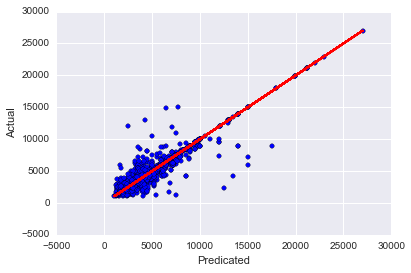

In [393]:
plot_pred(y_pred, y_test, y)

In [394]:
f_importance(df_alt_Ns)

[(0.16635636782963586, 'latitude'),
 (0.16625963685950057, 'longitude'),
 (0.12009477586413377, 'sq_ft'),
 (0.079118587231827409, 'name'),
 (0.069056456679407088, 'user_Ns'),
 (0.06351681402008158, 'parking'),
 (0.058386919896009914, 'GIS_Ns'),
 (0.053050967818555519, 'laundry'),
 (0.044998582258957344, 'bedrooms'),
 (0.03950966725920526, 'no smoking'),
 (0.037898238961664374, 'bathrooms'),
 (0.031372717203217673, 'apa'),
 (0.021738827808459746, 'cats_OK'),
 (0.018860579847820854, 'dogs_OK'),
 (0.01631575377894821, 'furnished'),
 (0.013465106682574892, 'wheelchair')]

In [395]:
percent_perfect(y_pred, y_test)

percent perfect:  0.302040816327


## Maps

In [396]:
no_GIS_Ns = df_alt_Ns.drop('GIS_Ns', axis = 1)

In [397]:
X, y = makeXy(no_GIS_Ns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)

In [398]:
%%time
est = RF(n_estimators = 50)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print mean_squared_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred) **.5
print mean_absolute_error(y_test, y_pred)

363436.914688
602.857292142
265.162462908
CPU times: user 8.06 s, sys: 3.7 s, total: 11.8 s
Wall time: 12.4 s


In [399]:
f_importance(no_GIS_Ns)

[(0.17427234278478157, 'longitude'),
 (0.17358399678416001, 'latitude'),
 (0.12139341304355973, 'sq_ft'),
 (0.099303101715380468, 'name'),
 (0.088860867269862254, 'user_Ns'),
 (0.06624842075852172, 'parking'),
 (0.055083974547587712, 'laundry'),
 (0.04406645114377615, 'bedrooms'),
 (0.0400243896531432, 'bathrooms'),
 (0.038517200880563263, 'no smoking'),
 (0.035998407384534102, 'apa'),
 (0.01685983904762162, 'furnished'),
 (0.016327177636869538, 'cats_OK'),
 (0.01586410246272682, 'dogs_OK'),
 (0.013596314886911846, 'wheelchair')]

In [400]:
no_name_Ns = df_alt_Ns.drop('name', axis = 1)

In [401]:
X, y = makeXy(no_name_Ns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)

In [402]:
%%time
est = RF(n_estimators = 50)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print mean_squared_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred) **.5
print mean_absolute_error(y_test, y_pred)

369844.52411
608.148439207
272.980341246
CPU times: user 7.57 s, sys: 3.43 s, total: 11 s
Wall time: 11.6 s


In [403]:
f_importance(no_name_Ns)

[(0.18081930764033319, 'longitude'),
 (0.1796287594220855, 'latitude'),
 (0.12446620608155708, 'sq_ft'),
 (0.085435460342173308, 'user_Ns'),
 (0.077623660669070463, 'GIS_Ns'),
 (0.067816337480745684, 'parking'),
 (0.056941168711843286, 'laundry'),
 (0.046109919349531472, 'bedrooms'),
 (0.04040880981904621, 'bathrooms'),
 (0.038541542098520266, 'no smoking'),
 (0.035200967932034956, 'apa'),
 (0.019366202328722822, 'cats_OK'),
 (0.017317682467204998, 'furnished'),
 (0.016616251158202228, 'dogs_OK'),
 (0.013707724498928597, 'wheelchair')]

In [404]:
no_user_Ns = df_alt_Ns.drop('user_Ns', axis = 1)

In [405]:
X, y = makeXy(no_user_Ns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)

In [406]:
%%time
est = RF(n_estimators = 50)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print mean_squared_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred) **.5
print mean_absolute_error(y_test, y_pred)

434918.27819
659.483341859
272.198813056
CPU times: user 7.54 s, sys: 2.89 s, total: 10.4 s
Wall time: 11.4 s


In [407]:
f_importance(no_user_Ns)

[(0.17584639182563319, 'longitude'),
 (0.17383428168014967, 'latitude'),
 (0.12410981180924914, 'sq_ft'),
 (0.094783799057988588, 'name'),
 (0.077098929163685256, 'GIS_Ns'),
 (0.066653449316160088, 'parking'),
 (0.056120099836774476, 'laundry'),
 (0.048428319836226794, 'bedrooms'),
 (0.040142757597545306, 'bathrooms'),
 (0.039868096613097814, 'no smoking'),
 (0.036375087782600513, 'apa'),
 (0.019229404182816504, 'cats_OK'),
 (0.01763315695837148, 'furnished'),
 (0.016828688490416362, 'dogs_OK'),
 (0.013047725849284826, 'wheelchair')]

## Imputing Sq_ft

In [408]:
df_sq_ft = df_alt_Ns.drop(['rent', 'sq_ft'], axis = 1)

In [409]:
le = preprocessing.LabelEncoder()
df_le = pd.DataFrame()
for col in df_sq_ft:
    if df_sq_ft[col].dtype == 'object':
        df_le[col] = le.fit_transform(df_sq_ft[col])
    else:
        df_le[col] = df_sq_ft[col]

In [410]:
im = preprocessing.Imputer(copy = False)
df_le = im.fit_transform(df_le)
df_le = preprocessing.scale(df_le)

In [411]:
temp_df = pd.DataFrame(df_le)

In [412]:
temp_df['sq_ft'] = df_alt_Ns.sq_ft

In [413]:
temp_df_nn = temp_df[temp_df.sq_ft.notnull()]

In [414]:
X = temp_df_nn.drop('sq_ft', axis = 1).values

In [415]:
y = temp_df_nn.sq_ft

In [416]:
est = RF(n_estimators = 50)
est.fit(X, y)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [417]:
cols = df_sq_ft.columns
sorted(zip(est.feature_importances_, cols), reverse = True)

[(0.17011043943403611, 'longitude'),
 (0.16806786631292867, 'latitude'),
 (0.08859188104897775, 'name'),
 (0.078320096823585539, 'parking'),
 (0.074609045878951272, 'user_Ns'),
 (0.07181641871633547, 'GIS_Ns'),
 (0.066942576816950095, 'bedrooms'),
 (0.056308925490662104, 'laundry'),
 (0.056196794775561283, 'bathrooms'),
 (0.04716420938665708, 'apa'),
 (0.03985860776969153, 'no smoking'),
 (0.022399320805882958, 'cats_OK'),
 (0.021708547346750148, 'dogs_OK'),
 (0.02084837866078125, 'wheelchair'),
 (0.017056890732248749, 'furnished')]

In [418]:
X = temp_df.drop('sq_ft', axis = 1).values

In [419]:
y_pred = est.predict(X)

In [420]:
df_alt_Ns_p = df_alt_Ns.copy(deep = True)

In [421]:
df_alt_Ns_p['sq_ft_pred'] = y_pred

In [422]:
sq_index = df_alt_Ns_p[df_alt_Ns_p.sq_ft.notnull()].index

In [423]:
df_alt_Ns_p.sq_ft_pred.ix[sq_index] = df_alt_Ns_p.sq_ft.ix[sq_index]

## Predicted Sq_ft

In [429]:
df_alt_Ns_p = df_alt_Ns_p.drop('sq_ft', axis = 1)

In [430]:
X, y = makeXy(df_alt_Ns_p)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)

In [431]:
%%time
est = RF(n_estimators = 50)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print mean_squared_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred) **.5
print mean_absolute_error(y_test, y_pred)

439497.90319
662.946380328
277.679154303
CPU times: user 8.48 s, sys: 2.78 s, total: 11.3 s
Wall time: 11.7 s


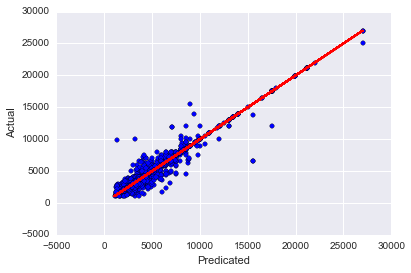

In [432]:
plot_pred(y_pred, y_test, y)

In [433]:
f_importance(df_alt_Ns_p)

[(0.16721213539927543, 'longitude'),
 (0.16465301525792653, 'latitude'),
 (0.13812909144591728, 'sq_ft_pred'),
 (0.077048128549537201, 'name'),
 (0.067990504682998332, 'user_Ns'),
 (0.063586983389925397, 'parking'),
 (0.058073439965891635, 'GIS_Ns'),
 (0.053235034756382166, 'laundry'),
 (0.038565364607955059, 'no smoking'),
 (0.036987301933182032, 'bedrooms'),
 (0.033785608916496651, 'apa'),
 (0.032628031820457919, 'bathrooms'),
 (0.020461913669670401, 'cats_OK'),
 (0.018584116033187336, 'dogs_OK'),
 (0.015836989423674386, 'furnished'),
 (0.013222340147522113, 'wheelchair')]

## PCA

In [534]:
X, y = makeXy(df_no_dups)

In [535]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [536]:
X.shape[1]

17

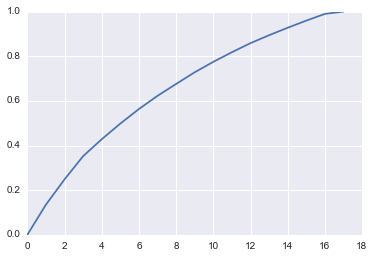

In [538]:
X_scale = preprocessing.scale(X)
comp = np.arange((X.shape[1] + 1))
explained_var = []
for i in comp:
    pca = PCA(n_components= i)
    X_pca = pca.fit_transform(X_scale)
    explained_var.append(pca.explained_variance_ratio_.sum())
plt.plot(comp, explained_var)

In [445]:
pca = PCA(n_components = 10)
X_pca = pca.fit_transform(X)

In [446]:
y = df_alt_Ns.rent

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = .2, random_state = 1)

In [448]:
%%time
est = RF(n_estimators = 50)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print mean_squared_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred) **.5
print mean_absolute_error(y_test, y_pred)

804041.676929
896.683710641
363.34458457
CPU times: user 35.3 s, sys: 3.54 s, total: 38.8 s
Wall time: 41.1 s


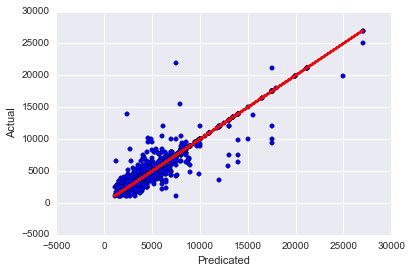

In [449]:
plot_pred(y_pred, y_test, y)

In [454]:
percent_perfect(y_pred, y_test)

percent perfect:  0.404673590504


In [456]:
df_reduce = df_alt_Ns.copy(deep = True)

In [459]:
df_reduce.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13478 entries, 0 to 13477
Data columns (total 17 columns):
apa           13473 non-null object
bathrooms     12819 non-null float64
bedrooms      13473 non-null float64
cats_OK       13478 non-null int64
dogs_OK       13478 non-null int64
furnished     13478 non-null int64
latitude      13478 non-null float64
laundry       9755 non-null object
longitude     13478 non-null float64
user_Ns       13337 non-null object
no smoking    13478 non-null int64
parking       8175 non-null object
rent          13478 non-null float64
sq_ft         6308 non-null float64
wheelchair    13478 non-null int64
GIS_Ns        13478 non-null object
name          13478 non-null object
dtypes: float64(6), int64(5), object(6)
memory usage: 1.9+ MB


In [461]:
df_reduce['counts'] = 1

In [473]:
df_no_dups = df_reduce.groupby(df_reduce.columns[:-1].tolist()).sum().sort(columns = 'counts')[::-1].reset_index()

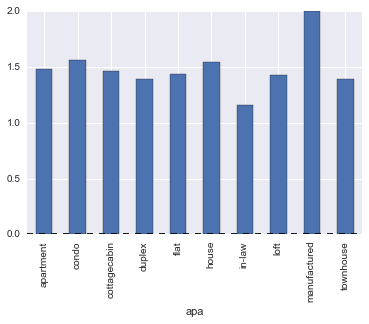

In [500]:
df_no_dups.groupby('apa').counts.mean().plot(kind = 'bar')

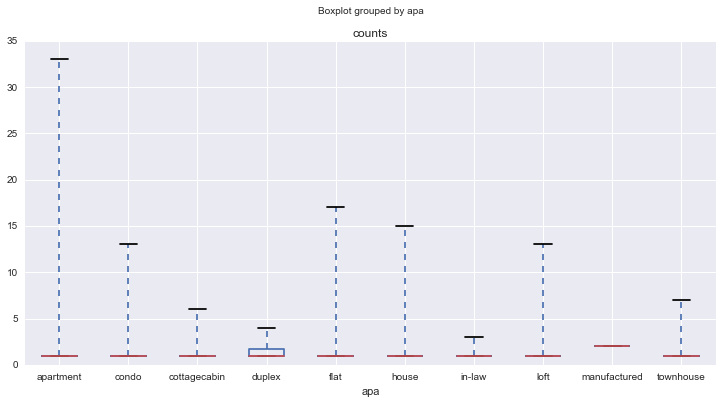

In [499]:
df_no_dups.boxplot(column = 'counts', by = 'apa', figsize = (12,6));

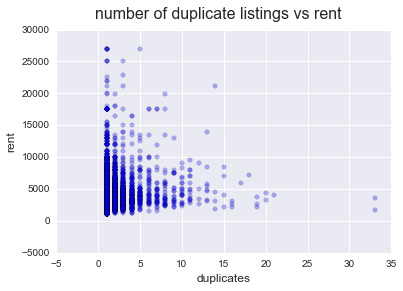

In [509]:
fig = plt.figure()
plt.scatter(df_no_dups.counts, df_no_dups.rent, alpha = .3)
fig.suptitle('number of duplicate listings vs rent', fontsize=16)
plt.xlabel('duplicates', fontsize=12)
plt.ylabel('rent', fontsize=12)
plt.show()



In [525]:
def makeXy_d(df):
    le = preprocessing.LabelEncoder()
    df_le = pd.DataFrame()
    for col in df:
        if df[col].dtype == 'object':
            df_le[col] = le.fit_transform(df[col])
        else:
            df_le[col] = df[col]
    X = df_le.drop('rent', axis=1)
    im = preprocessing.Imputer(copy = False)
    X = im.fit_transform(X)
    X = preprocessing.scale(X)
    y = df.rent.values
    return X, y

In [540]:
df_no_dups = df_no_dups.drop('counts', axis = 1)

In [541]:
X, y = makeXy_d(df_no_dups)

In [542]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)

In [543]:
%%time
est = RF(n_estimators = 50)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print mean_squared_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred) **.5
print mean_absolute_error(y_test, y_pred)

1040530.04073
1020.06374346
460.278481013
CPU times: user 7.2 s, sys: 2.67 s, total: 9.88 s
Wall time: 10.4 s


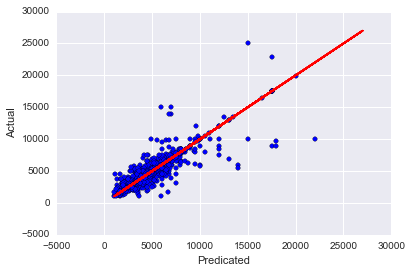

In [544]:
plot_pred(y_pred, y_test, y)

In [545]:
f_importance(df_no_dups)

[(0.16776874264420058, 'longitude'),
 (0.16775901269308324, 'latitude'),
 (0.11431496259645625, 'sq_ft'),
 (0.084395889543754238, 'name'),
 (0.078011321448159143, 'user_Ns'),
 (0.067369603109417198, 'parking'),
 (0.062450767892349261, 'GIS_Ns'),
 (0.044940782382018048, 'laundry'),
 (0.042993075778635578, 'no smoking'),
 (0.039675072223835844, 'bedrooms'),
 (0.03352755344172971, 'apa'),
 (0.031068471976482978, 'bathrooms'),
 (0.017895176801708535, 'furnished'),
 (0.017087746866781686, 'cats_OK'),
 (0.015686570135674628, 'dogs_OK'),
 (0.015055250465713059, 'wheelchair')]

In [546]:
percent_perfect(y_pred, y_test)

percent perfect:  0.170060539351
